In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data.txt")

In [3]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [4]:
df1 = df.reset_index()['Close']

In [5]:
df1.head()

0    233.75
1    233.25
2    234.25
3    236.10
4    233.30
Name: Close, dtype: float64

In [6]:
df1.shape

(2035,)

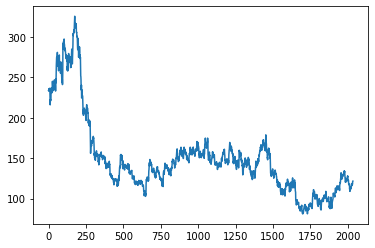

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
# LSTM are sensitive to the scale of the data.So we apply MinMax Scale
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))


In [9]:
df1.shape

(2035, 1)

In [10]:
# Splitting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0 : training_size,:],df1[training_size : len(df1), : 1]

In [11]:
# Convert an array value into a dataset matrix
def create_dataset(dataset,time_step=1):
    data_X,data_Y = [],[]
    for i in range(len(dataset) - time_step-1):
        a = dataset[i : (i+time_step),0]
        data_X.append(a)
        data_Y.append(dataset[i+time_step,0])
    return np.array(data_X),np.array(data_Y)


In [12]:
# reshape into X = t,t+1,t+2,t+3 and Y = t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [13]:
print(X_train.shape),print(y_train.shape)

(1221, 100)
(1221,)


(None, None)

In [14]:
print(X_test.shape),print(y_test.shape)

(612, 100)
(612,)


(None, None)

In [15]:
# Reshape input to be [samples,time_steps,features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
# Create the LSTM model
# import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [17]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 14s 258ms/step - loss: 0.0274 - val_loss: 0.0074
Epoch 2/100
20/20 [==============================] - 4s 184ms/step - loss: 0.0033 - val_loss: 9.1591e-04
Epoch 3/100
20/20 [==============================] - 4s 187ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/100
20/20 [==============================] - 4s 186ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/100
20/20 [==============================] - 4s 188ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/100
20/20 [==============================] - 4s 188ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/100
20/20 [==============================] - 4s 188ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/100
20/20 [==============================] - 4s 189ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
20/20 [==============================] - 4s 191ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/100
20/20 [==============================] - 4s 191ms/step - loss: 0.0015 - v

In [20]:
import tensorflow as tf

In [21]:
tf.__version__

'2.6.0'

In [22]:
# Let's do the predictions and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [23]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [24]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

162.32631915060284

In [25]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

114.48311410791126

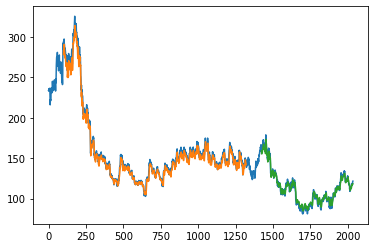

In [26]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [27]:
# Predict the future 30 days and plot the output
713- 100

613

In [28]:
len(test_data)

713

In [33]:
x_input = test_data[613: ].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [35]:
temp_input

[0.12479575163398693,
 0.1384803921568627,
 0.14011437908496732,
 0.1388888888888889,
 0.13541666666666663,
 0.14011437908496732,
 0.13807189542483655,
 0.130718954248366,
 0.130718954248366,
 0.12867647058823528,
 0.11846405228758167,
 0.14644607843137253,
 0.1480800653594771,
 0.159109477124183,
 0.15992647058823523,
 0.1578839869281045,
 0.16441993464052285,
 0.178921568627451,
 0.17933006535947704,
 0.19260620915032678,
 0.2081290849673203,
 0.18974673202614378,
 0.18055555555555558,
 0.1823937908496731,
 0.17708333333333326,
 0.17810457516339862,
 0.18055555555555558,
 0.17810457516339862,
 0.17851307189542487,
 0.196078431372549,
 0.18913398692810457,
 0.1895424836601307,
 0.19403594771241828,
 0.19444444444444442,
 0.20200163398692816,
 0.19771241830065356,
 0.19934640522875813,
 0.19873366013071891,
 0.19975490196078427,
 0.21282679738562094,
 0.21568627450980393,
 0.2044526143790849,
 0.21772875816993464,
 0.21098856209150318,
 0.21425653594771243,
 0.1975081699346406,
 0.1881

In [36]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16033639]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [37]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:
import matplotlib.pyplot as plt

In [39]:
len(df1)

2035

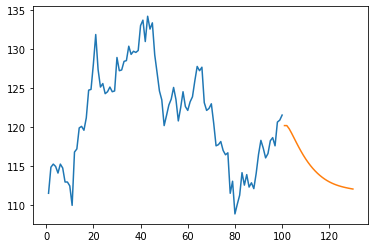

In [41]:
plt.plot(day_new,scaler.inverse_transform(df1[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

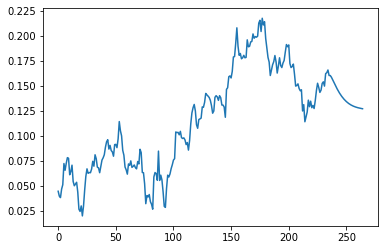

In [43]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1800:])

In [44]:
df3=scaler.inverse_transform(df3).tolist()

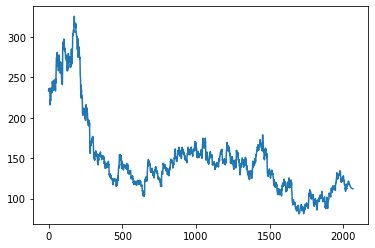

In [45]:
plt.plot(df3)